In [1]:
try:
    from lmfit_global import LmfitGlobal
except (ImportError, ModuleNotFoundError):
    import sys
    sys.path.append('../lmfit_global')
    from lmfit_global import LmfitGlobal
    
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
from scipy.special import erf, erfc
log2 = np.log(2)
s2pi = np.sqrt(2*np.pi)
s2 = np.sqrt(2.0)
# tiny had been numpy.finfo(numpy.float64).eps ~=2.2e16.
# here, we explicitly set it to 1.e-15 == numpy.finfo(numpy.float64).resolution
tiny = 1.0e-15

def not_zero(value):
    """Return value with a minimal absolute size of tiny, preserving the sign.

    This is a helper function to prevent ZeroDivisionError's.

    Parameters
    ----------
    value : scalar
        Value to be ensured not to be zero.

    Returns
    -------
    scalar
        Value ensured not to be zero.

    """
    return float(np.copysign(max(tiny, abs(value)), value))


def gaussian(x, amplitude=1.0, center=0.0, sigma=1.0):
    """Return a 1-dimensional Gaussian function.

    gaussian(x, amplitude, center, sigma) =
        (amplitude/(s2pi*sigma)) * exp(-(1.0*x-center)**2 / (2*sigma**2))

    """
    return ((amplitude/(max(tiny, s2pi*sigma)))
            * np.exp(-(1.0*x-center)**2 / max(tiny, (2*sigma**2))))


def rho_gaussian(x, amplitude=1.0, magmom=1.0, sigma=1.0, offset=0.0, dipolar=None, x_target=None):
    """
    Compute the field distribution that follows normal Gaussian lineshape for for multiple dipolar fields.
    
    Parameters:
    -----------
    x : array_like
        Independent variable (e.g. frequency).
    amplitude : float
        Amplitude/weight of each Gaussian.
    magmom : float
        Magnetic moment scaling factor.
    sigma : float
        Standard deviation (width).
    offset : float
        Constant offset/background.
    dipolar : array_like
        Dipolar field centers (scaled by magmom).
    x_target : array_like, optional
        If provided, interpolate result onto these points.
    
    Returns:
    --------
    array_like
        Summed Gaussian distribution.
    """
    if dipolar is None:
        raise ValueError("dipolar must be provided for this calculation.")
    dipolar = np.array(dipolar) * magmom  # Units/mu_B * mu_B

    # vectorized sum of Gaussians
    rho = np.sum([gaussian(x, amplitude=np.abs(amplitude), center=c, sigma=sigma)
                  for c in dipolar], axis=0)

    rho = rho + offset
    # Is interpolation really necessary, the x data should be enough???
    if x_target is not None:
        return np.interp(x_target, x, rho)
    return rho

def get_muon_field_conversion_factor(from_unit: str, to_unit: str) -> float:
    """
    Return the conversion factor such that:
        value_in_to_unit = value_in_from_unit * factor

    Base unit is Gauss (G).
    gamma_mu = 0.0135538817 MHz/Gauss.
    """
    gamma_mu = 0.0135538817  # MHz per Gauss

    from_unit = from_unit.lower()
    to_unit = to_unit.lower()

    # Gauss per unit
    factors = {
        "g": 1.0,                # 1 G = 1 G
        "t": 1e4,                # 1 T = 10000 G
        "mt": 10.0,              # 1 mT = 10 G
        "mhz": 1.0 / gamma_mu,   # 1 MHz = (1/gamma_mu) G
    }

    if from_unit not in factors or to_unit not in factors:
        raise ValueError(f"Unsupported units: {from_unit}, {to_unit}")

    # Correct direction: gauss_per_from / gauss_per_to
    return factors[from_unit] / factors[to_unit]  

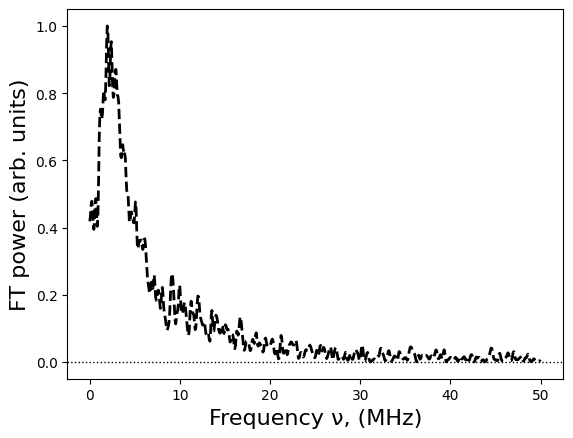

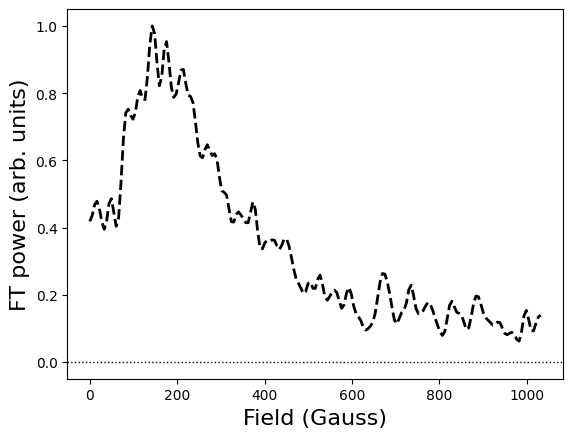

In [3]:
import os
import copy
from typing import Union
from scipy.signal import find_peaks

def index_range_of(
    arrval: Union[np.ndarray, list],
    minval: float,
    maxval: float,
    inclusive: bool = True
) -> np.ndarray:
    """
    Return indices of elements within the specified range [minval, maxval].

    Parameters
    ----------
    arrval : array_like
        The array to search.
    minval : float
        The lower bound of the range.
    maxval : float
        The upper bound of the range.
    inclusive : bool, optional (default=True)
        If True, include elements equal to minval or maxval.
        If False, use strict inequalities (minval < x < maxval).

    Returns
    -------
    numpy.ndarray
        Indices of elements within the range.

    Raises
    ------
    ValueError
        If minval > maxval.
    """
    arrval = np.asarray(arrval)

    if minval > maxval:
        raise ValueError("minval must be less than or equal to maxval.")

    if inclusive:
        mask = (arrval >= minval) & (arrval <= maxval)
    else:
        mask = (arrval > minval) & (arrval < maxval)

    return np.where(mask)[0]

################################################################################
dpath = './data'  # data path

# --- Load data (skip header) ---
file='fourier_transform_field.dat' # data
file=os.path.join(
    dpath,
    file
)

fftdat = np.loadtxt(
    file, 
    delimiter=None,
    # comments='#',
    # skiprows=1
)

xdata = fftdat[:,0]   # MHz
yreal = fftdat[:,1]
yimgr = fftdat[:,2]
yerr  = fftdat[:,3]
#
ydata = yreal # FFT real
if True:  # FFT power
    ydata = yreal**2 +  yimgr**2
# normalize ydata
if True:
    peaks, _ = find_peaks(ydata)
    mpeak=np.max(ydata[peaks])   
    # ydata=ydata/mpeak     
    ydata/=mpeak

plt.plot(
    xdata,
    ydata,
    color='k',
    ls='dashed',
    lw=2,
)

ylabel=r'FFT (arb. units)'
ylabel=r'FT power (arb. units)'
plt.ylabel(ylabel, fontsize=16, fontweight='normal')
plt.xlabel(r'Frequency ν, (MHz)', fontsize=16, fontweight='normal')
plt.axhline(y=0.00, color='k', linestyle='dotted', linewidth=1)

plt.show()

# Convert from MHz to Gauss
conv_factor = get_muon_field_conversion_factor(
    from_unit='MHz',
    to_unit='G'
) 
#
xdat = copy.deepcopy(xdata) * conv_factor
ydat = copy.deepcopy(ydata)
edat = copy.deepcopy(yerr)
# --- Only interested on some portion of the data ---
# between 0 Gauss and 1033 Gauss (~14 MHz)

idx = index_range_of(xdat, minval=0.0, maxval=1033.0, inclusive=True)
xdat = np.take(xdat, idx)
ydat = np.take(ydat, idx)
yerr = np.take(edat, idx)

xy_dat = np.column_stack([xdat, ydat])

XY_DAT = copy.deepcopy(xy_dat)

plt.plot(
    xdat,
    ydat,
    color='k',
    ls='--',
    lw=2,
)

ylabel=r'FFT (arb. units)'
ylabel=r'FT power (arb. units)'
plt.ylabel(ylabel, fontsize=16, fontweight='normal')
plt.xlabel(r'Field (Gauss)', fontsize=16, fontweight='normal')
plt.axhline(y=0.00, color='k', linestyle='dotted', linewidth=1)

plt.show()

In [4]:
def create_items(dipolar, x_target=None):
    """
    """
    # data dict
    data_dict = {
        'xy': XY_DAT,         # data_xy, i.e numpy.column_stack([x, y_0, y_1, ..., y_n])
        'xrange': None    # x range in (min, max) of the data range to fit, default is None
        }
    
    func_lst = [
        {
            'func_name': rho_gaussian,
            'init_params' : {
                'amplitude': {'value':5, 'vary':True, 'min':0, 'max':12},
                'magmom': {'value':0.06, 'vary':True, 'min':0, 'max':1.0},
                'sigma': {'value':100, 'vary':True, 'min':0, 'max':300},
                'offset': {'value':0.15276920, 'vary':False, 'min':0, 'max':1},
            },
            'func_kws': {'dipolar': dipolar, 'x_target':x_target}   # <-- Additional keyword arguments to pass to model function `'func_name'`.
            # YOU CAN PLAY AROUND WITH DIFFERENT 'form' AND SEE THE BEHAVIOR OF THE FIT
        },
    ]

    # function dict
    function_dict = {
        'theory': func_lst,
        'theory_connectors': ['+'],
    }


    # """
    # # --- The `theory_connectors` (list of str): 
    #     A list of binary operators (e.g., '+', '-', '*', '/') that define how to combine 
    #     the theory functions listed in 'theory'. Each operator connects one function to the next 
    #     in left-to-right order. 
        
    #     For example: 
    #     - ['+', '+'] means: theory[0] + theory[1] + theory[2].

    #     - ['+', '*'] means: theory[0] + theory[1] * theory[2].

    #     The number of connectors must be exactly one less than the number of theory functions.
    #     The ONLY (so-far) supported operators are: '+', '-', '*', '/'.
    # """


    # items 
    items = {
        'data': data_dict,              # 1. data (see above)
        'functions': function_dict,     # 2. thoery (see above)
    }
    return items

In [5]:
# --- Load dipolar data file ---
file='dario_unrlx_calcdipolar_field.npz' # data
file=os.path.join(
    dpath,
    file
)

loaded = np.load(file, allow_pickle=True)

# Access stored items
propagation = loaded["propagation"].item()
up = loaded["up"]
down = loaded["down"]
matrix = loaded["matrix"]
dipolar = loaded["data"]
print(f'The dipolar data is in unit of: {loaded["unit"]}')
# Convert from Tesla to Gauss
conv_factor1 = get_muon_field_conversion_factor(
    from_unit='T',
    to_unit='G'
) 

dipolar*=conv_factor1

The dipolar data is in unit of: Tesla


In [6]:
items = create_items(dipolar, x_target=None)
LFG = LmfitGlobal(items)
# --- The box below show how the model y(x) (CompositeModel) is define using `theory_connectors` define above ---
# --- it is upto the USER to define how to define the CompositeModel ---
# --- if you are HAPPY proceed NEXT

INFO: Validating data...
INFO: Validating functions...
INFO: Validating nan policy...
INFO: Creating lmfit.Models for the functions...
INFO: Initializing lmfit.Parameters for the functions...
INFO: Setting lmfit fitting/minimization protocols for the functions...
INFO: ################################################################################
INFO: # y(x;) = rho_gaussian(x, amplitude, magmom, sigma, offset, dipolar, x_target) #
INFO: ################################################################################


Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude_0         5        0       12     None     True     None     None
magmom_0         0.06        0        1     None     True     None     None
offset_0       0.1528        0        1     None    False     None     None
sigma_0           100        0      300     None     True     None     None


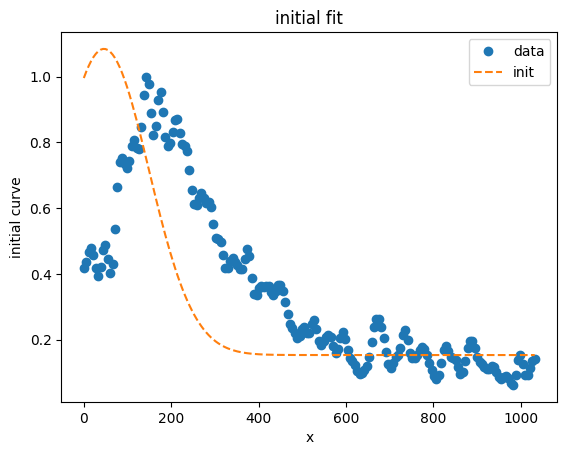

In [7]:
LFG.initial_params.pretty_print()  # pretty print initial parameters

axes0 = LFG.plot_init()  # plot init parameters
plt.show()

In [8]:
def per_iteration(pars, iteration, resid, *args, **kws):
    print(" ITER ", iteration, [f"{p.name} = {p.value:.5f}" for p in pars.values()])

LFG.fit(verbose=False, iter_cb=per_iteration)  # verbose, if True will show fit parameters

print(f'Nfev = {LFG.result.nfev}')

INFO: Fitting DONE...


 ITER  -1 ['amplitude_0 = 5.00000', 'magmom_0 = 0.06000', 'sigma_0 = 100.00000', 'offset_0 = 0.15277']
 ITER  0 ['amplitude_0 = 5.00000', 'magmom_0 = 0.06000', 'sigma_0 = 100.00000', 'offset_0 = 0.15277']
 ITER  1 ['amplitude_0 = 5.00000', 'magmom_0 = 0.06000', 'sigma_0 = 100.00000', 'offset_0 = 0.15277']
 ITER  2 ['amplitude_0 = 5.00001', 'magmom_0 = 0.06000', 'sigma_0 = 100.00000', 'offset_0 = 0.15277']
 ITER  3 ['amplitude_0 = 5.00000', 'magmom_0 = 0.06000', 'sigma_0 = 100.00000', 'offset_0 = 0.15277']
 ITER  4 ['amplitude_0 = 5.00000', 'magmom_0 = 0.06000', 'sigma_0 = 100.00048', 'offset_0 = 0.15277']
 ITER  5 ['amplitude_0 = 5.92029', 'magmom_0 = 0.08775', 'sigma_0 = 192.47759', 'offset_0 = 0.15277']
 ITER  6 ['amplitude_0 = 5.92029', 'magmom_0 = 0.08775', 'sigma_0 = 192.47759', 'offset_0 = 0.15277']
 ITER  7 ['amplitude_0 = 5.92029', 'magmom_0 = 0.08775', 'sigma_0 = 192.47759', 'offset_0 = 0.15277']
 ITER  8 ['amplitude_0 = 5.92029', 'magmom_0 = 0.08775', 'sigma_0 = 192.47800', '

In [9]:
LFG.report()

[[Model]]
    Model(rho_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 189
    # variables        = 3
    chi-square         = 0.87630495
    reduced chi-square = 0.00471132
    Akaike info crit   = -1009.64596
    Bayesian info crit = -999.920719
    R-squared          = 0.92869141
[[Variables]]
    amplitude_0:  4.83036518 +/- 0.10860038 (2.25%) (init = 5)
    magmom_0:     0.22247115 +/- 0.00405953 (1.82%) (init = 0.06)
    sigma_0:      108.093367 +/- 5.56688166 (5.15%) (init = 100)
    offset_0:     0.1527692 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude_0, sigma_0)  = +0.7009
    C(magmom_0, sigma_0)     = -0.4822
    C(amplitude_0, magmom_0) = -0.2341


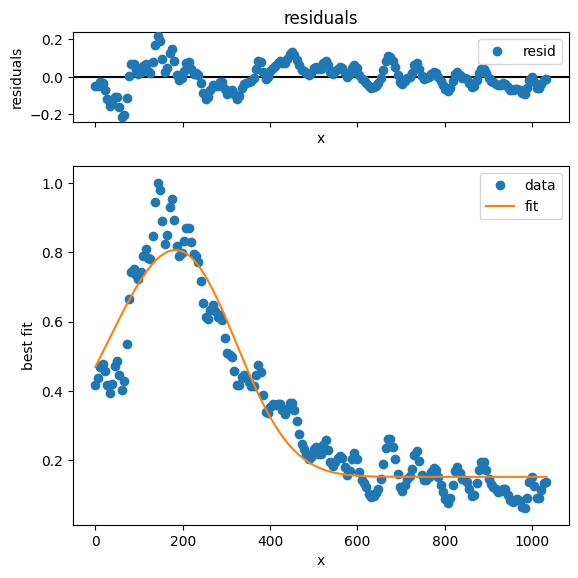

In [10]:
axes1 = LFG.plot(show_init=False)   # plot fit data & residuals and show initial plot (if True)
plt.show()

In [11]:
# # --- convert some fit parameters to desired units ----
# # since alpha was not defined in the func_lst functions above
# # we can add it using .update_params(); like
# value = get_muon_field_conversion_factor(
#     from_unit='G',
#     to_unit='mT'
# ) 
# conv_mT = ('conv_mT', value, True, None, None, None, None)
# LFG.update_params(conv_mT)
# conv_mT = ('sigma_0_conv_mT', value, True, None, None, None, None)
# LFG.update_params(conv_mT)

# # --- set "inequality" contrain below
# LFG.set_global_expr('sigma_0_conv_mT', expr='conv_mT * sigma_0')


# LFG.initial_params.pretty_print()  # pretty print initial parameters

In [12]:
# LFG.fit(verbose=False, iter_cb=per_iteration)  # verbose, if True will show fit parameters

# print(f'Nfev = {LFG.result.nfev}')

In [13]:
# LFG.report()

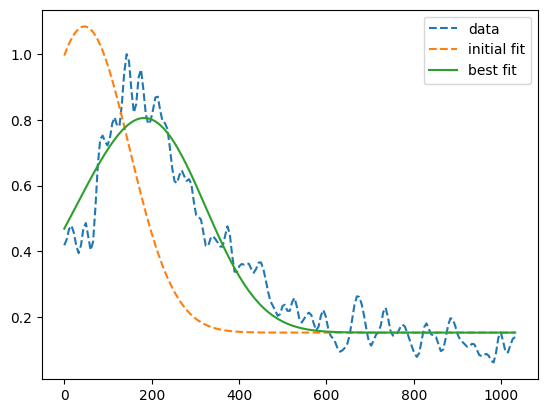

In [14]:
plt.plot(xdat, ydat, '--', label='data')

plt.plot(xdat, LFG.init_fit, '--', label='initial fit')
plt.plot(xdat, LFG.best_fit, '-', label='best fit')
plt.legend()
plt.show()